In [ ]:
!pip install vit-pytorch
!pip install graphviz
!pip install torchview
!pip install torchviz

In [ ]:
!pip uninstall torchcam -y
!pip install torchcam

Found existing installation: torchcam 0.4.0
Uninstalling torchcam-0.4.0:
  Successfully uninstalled torchcam-0.4.0
  Using cached torchcam-0.4.0-py3-none-any.whl.metadata (31 kB)
Using cached torchcam-0.4.0-py3-none-any.whl (46 kB)


In [ ]:
#go to the correct folder
%cd /content/drive/MyDrive/hyper-1

/content/drive/MyDrive/hyper-1


In [ ]:
import numpy as np

import torch
from torch import nn
from torchvision import transforms
import cv2
import torch.nn.functional as F


from PIL import Image
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
from model import ResNetModel_IFOF, ResNetModel_IF, EfficientNetModel_IF, EfficientNetModel_IFOF

In [ ]:
image_path = '/content/drive/MyDrive/WACV_engg_data/dataset/0/img10_66.jpg'  # Change this to your image path
feature_path = '/content/drive/MyDrive/WACV_engg_data/dataset/processed0/img10_66.csv'  # Change this to your feature path

In [ ]:
#change the model paths accordingly
Path_ResNet_IFOF = '/content/drive/MyDrive/hyper-1/best_model_ResNet_IFOF.pth'
Path_ResNet_IF = '/content/drive/MyDrive/hyper-1/best_model_ResNet_IF.pth'
Path_EfficientNet_IFOF = '/content/drive/MyDrive/hyper-1/best_model_EfficientNet_IFOF.pth'
Path_EfficientNet_IF = '/content/drive/MyDrive/hyper-1/best_model_EfficientNet_IF.pth'

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
img = cv2.imread(image_path)
img = img.reshape(img.shape[-1], img.shape[0], img.shape[1])
img = torch.tensor(img)
img.shape

image = normalize(resize(img, (224, 224)) / 255., [0.44730392, 0.43107784, 0.42404088], std=[0.1695384,  0.16244154, 0.16137291])


# IFOF

In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Function to overlay the heatmap on the original image
def show_cam_on_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    return img.unsqueeze(0)

# GradCAM Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, images, features):
        self.model.zero_grad()
        output = self.model(images, features)
        pred_class = output.argmax(dim=1)
        output[:, pred_class].backward()

        gradients = self.gradients
        activations = self.activations
        weights = F.adaptive_avg_pool2d(gradients, 1)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()

        return cam[0]

# Main function to apply Grad-CAM
def func(image_path, model_name, model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Specify target layers for Grad-CAM based on the model type
    if isinstance(model, ResNetModel_IFOF):
        target_layer_options = [
            model.image_cnn.layer4[1].conv2,  # The original layer in ResNet
            model.image_cnn.layer4[0].conv2,  # Earlier layer in ResNet
            model.image_cnn.layer3[1].conv2,  # Even earlier layer in ResNet
        ]
    elif isinstance(model, EfficientNetModel_IFOF):
        target_layer_options = [
            model.efficientnet.features[6],  # Layer 6 in EfficientNet
            model.efficientnet.features[5],  # Layer 5 in EfficientNet
            model.efficientnet.features[4],  # Layer 4 in EfficientNet
        ]

    for i, target_layer in enumerate(target_layer_options):
        print(f"\nTesting with target layer: {i + 1}")
        grad_cam = GradCAM(model, target_layer)

        img = preprocess_image(image_path)
        features = torch.randn(1, 709)  # Sample feature input

        heatmap = grad_cam(img.unsqueeze(0), features)

        if heatmap is None:
            print(f"Heatmap is None for target layer: {i + 1}. Skipping.")
            continue

        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        cam_img = show_cam_on_image(img / 255.0, heatmap)  # Normalize img for proper overlay

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Grad-CAM Layer {i + 1}")
        plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.savefig(f"{model_name}_grad_cam_layer_{i + 1}.pdf")
        plt.show()



Testing with target layer: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


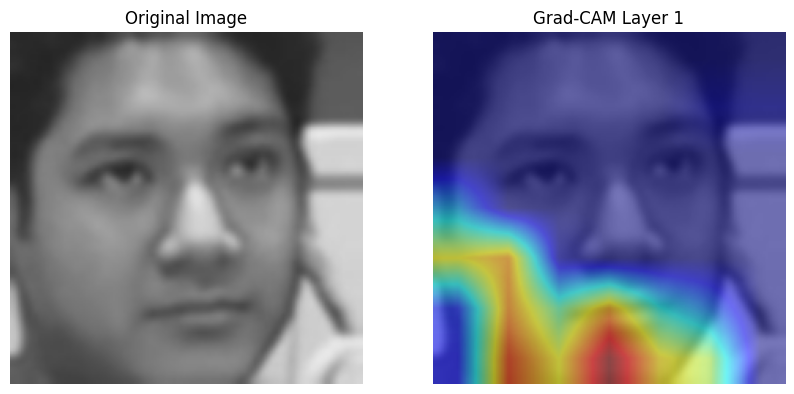


Testing with target layer: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


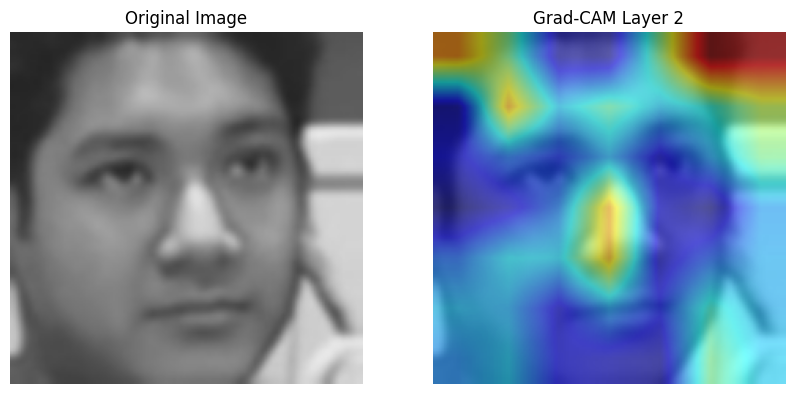


Testing with target layer: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


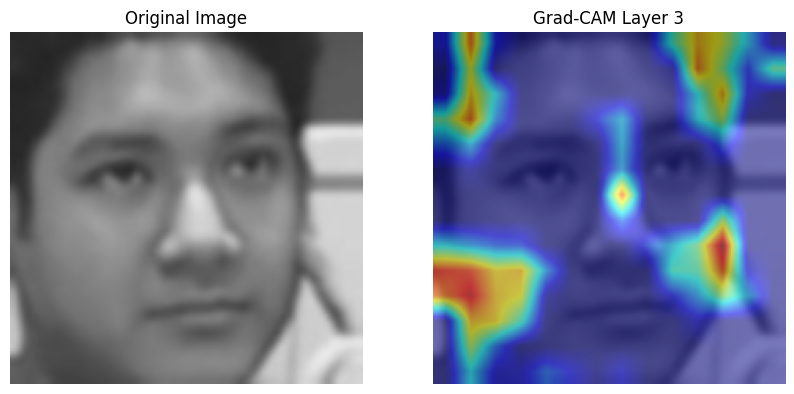

In [ ]:
# Load the model
ResNet_IFOF = ResNetModel_IFOF()
func(image_path, "ResNet_IFOF", ResNet_IFOF, Path_ResNet_IFOF)


Testing with target layer: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


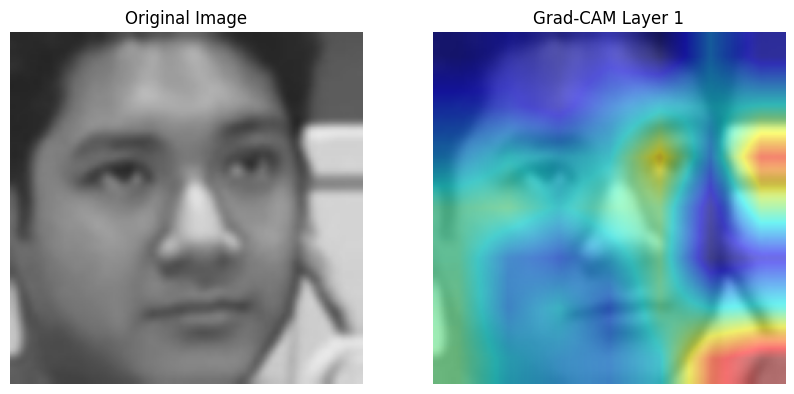


Testing with target layer: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


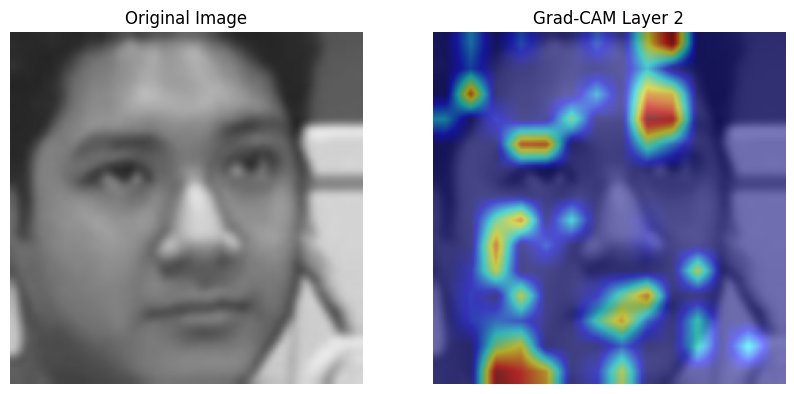


Testing with target layer: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


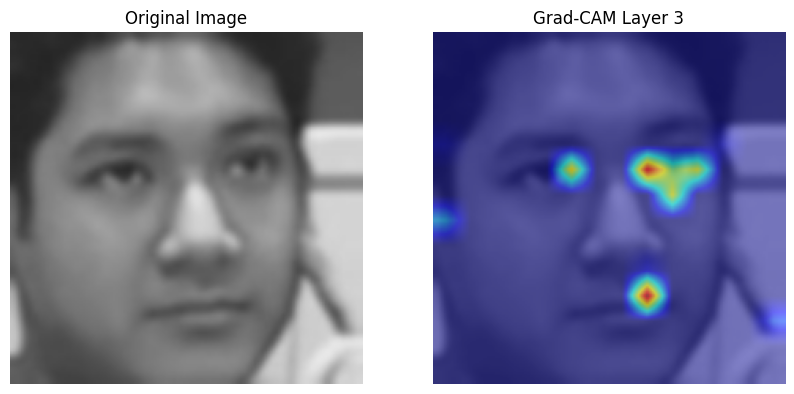

In [ ]:
# Load the model
EfficientNet_IFOF = EfficientNetModel_IFOF()
func(image_path, "EfficientNet_IFOF", EfficientNet_IFOF, Path_EfficientNet_IFOF)

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, images):
        self.model.zero_grad()
        output = self.model(images)
        pred_class = output.argmax(dim=1)
        output[:, pred_class].backward()

        gradients = self.gradients
        activations = self.activations
        weights = F.adaptive_avg_pool2d(gradients, 1)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()

        return cam[0]

def func(image_path, model_name, model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Specify target layers for Grad-CAM
    if isinstance(model, EfficientNetModel_IF):
        target_layer_options = [
            model.efficientnet.features[6],  # Layer 6 in EfficientNet
            model.efficientnet.features[5],  # Layer 5 in EfficientNet
            model.efficientnet.features[4],  # Layer 4 in EfficientNet
        ]
    elif isinstance(model, ResNetModel_IF):
        target_layer_options = [
            model.image_cnn.layer4[1].conv2,  # The original layer in ResNet
            model.image_cnn.layer4[0].conv2,  # Earlier layer in ResNet
            model.image_cnn.layer3[1].conv2,  # Even earlier layer in ResNet
        ]

    for i, target_layer in enumerate(target_layer_options):
        print(f"\nTesting with target layer: {i + 1}")
        grad_cam = GradCAM(model, target_layer)

        img = preprocess_image(image_path)

        heatmap = grad_cam(img)

        if heatmap is None:
            print(f"Heatmap is None for target layer: {i + 1}. Skipping.")
            continue

        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        cam_img = show_cam_on_image(img / 255.0, heatmap)  # Normalize img for proper overlay

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Grad-CAM Layer {i + 1}")
        plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.savefig(f"{model_name}_grad_cam_layer_{i + 1}.pdf")
        plt.show()



Testing with target layer: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


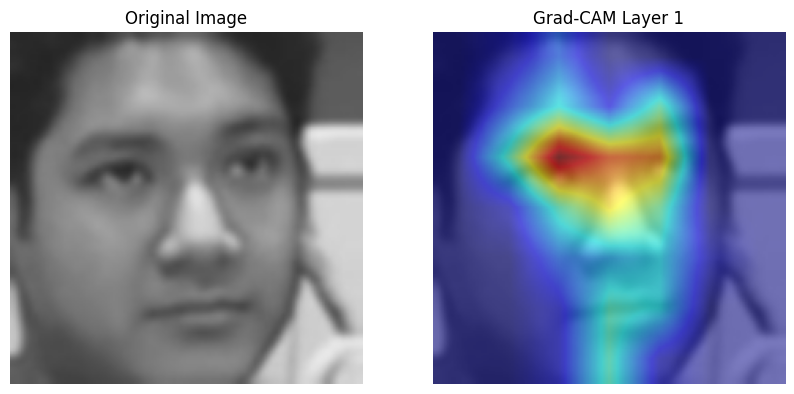


Testing with target layer: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


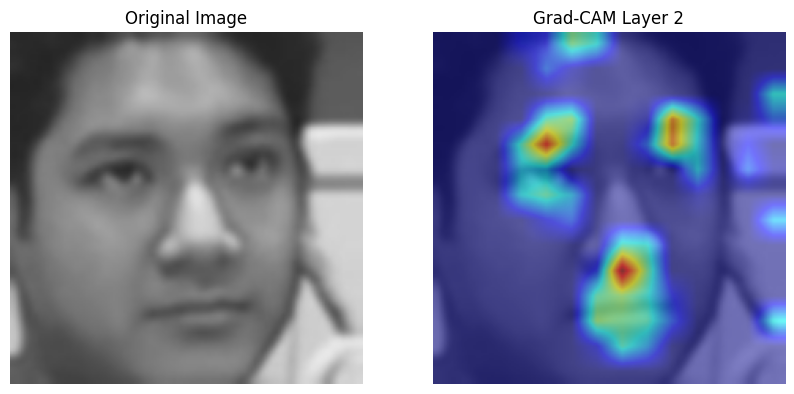


Testing with target layer: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


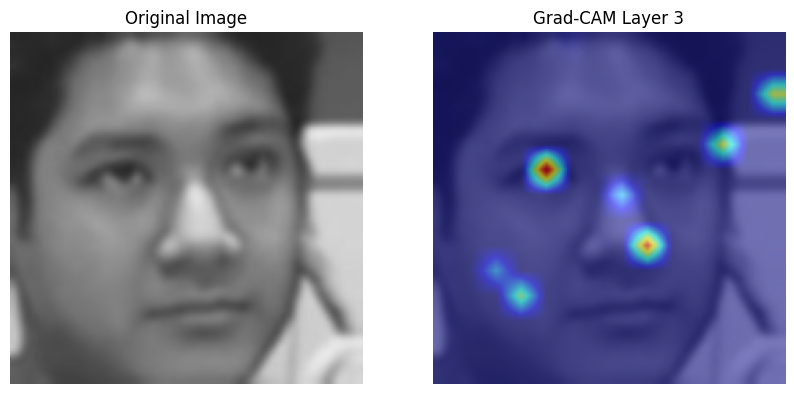

In [ ]:
# Load the model
EfficientNet_IF = EfficientNetModel_IF()
func(image_path, "EfficientNet_IF", EfficientNet_IF, Path_EfficientNet_IF)


Testing with target layer: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


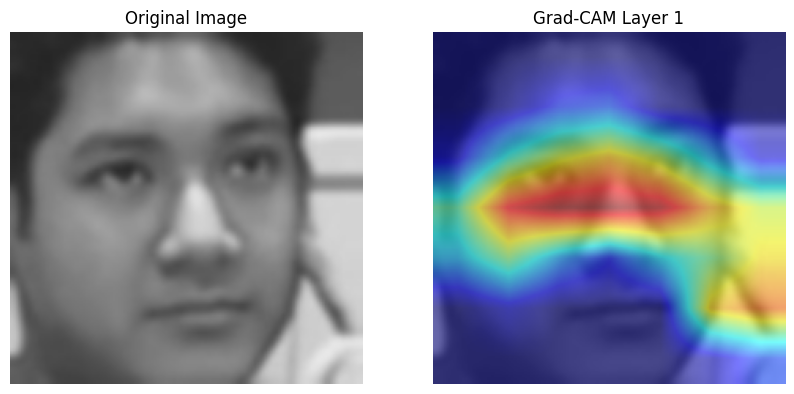


Testing with target layer: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


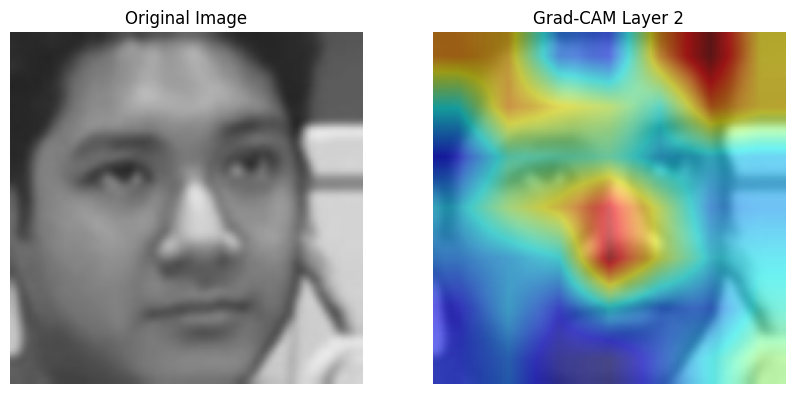


Testing with target layer: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


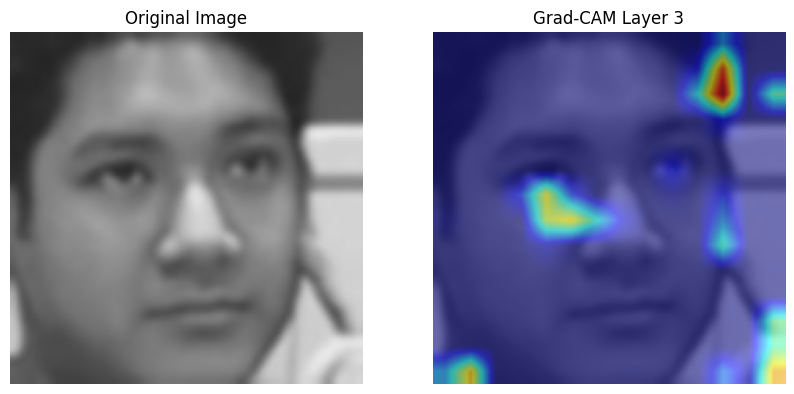

In [ ]:
# Load the model
ResNet_IF = ResNetModel_IF()
func(image_path, "ResNet_IF", ResNet_IF, Path_ResNet_IF)

# Freeze

In [ ]:
from model_freeze import ResNetModel_IFOF, ResNetModel_IF, EfficientNetModel_IF, EfficientNetModel_IFOF


In [ ]:
Path_FResNet_IFOF = '/content/drive/MyDrive/hyper-1/best_Fmodel_ResNet_IFOF.pth'
Path_FResNet_IF = '/content/drive/MyDrive/hyper-1/best_Fmodel_ResNet_IF.pth'
Path_FEfficientNet_IFOF = '/content/drive/MyDrive/hyper-1/best_Fmodel_EfficientNet_IFOF.pth'
Path_FEfficientNet_IF = '/content/drive/MyDrive/hyper-1/best_Fmodel_EfficientNet_IF.pth'

In [ ]:
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output
        print(f"Activations: {self.activations.shape}")

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        print(f"Gradients: {self.gradients.shape}")

    def forward(self, images, features):
        return self.model(images, features)

    def __call__(self, images, features, index=None):
        output = self.forward(images, features)

        if index is None:
            index = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[0, index]
        print(f"Class Score: {class_score.item()}")
        class_score.backward(retain_graph=True)

        if self.gradients is None:
            print("Gradients are not being captured.")
            return None

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        print(f"Pooled Gradients: {pooled_gradients}")

        if torch.all(pooled_gradients == 0):
            print("Pooled gradients are all zero.")
            return None

        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        print(f"Heatmap before ReLU: {heatmap}")

        heatmap = F.relu(heatmap)

        if torch.isnan(heatmap).any():
            print("NaN values found in heatmap, setting them to zero.")
            heatmap = torch.nan_to_num(heatmap, nan=0.0)

        heatmap = heatmap - heatmap.min()
        if heatmap.max() != 0:
            heatmap = heatmap / heatmap.max()

        print(f"Heatmap after normalization: {heatmap}")

        return heatmap.detach().cpu().numpy()

In [ ]:
# Function to overlay the heatmap on the original image
def show_cam_on_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    return img.unsqueeze(0)

# Main function to apply Grad-CAM
def func(image_path,model_name,model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Specify target layers for Grad-CAM
    target_layer_options = [
        model.image_cnn.layer4[1].conv2,  # The original layer
        model.image_cnn.layer4[0].conv2,  # Earlier layer
        model.image_cnn.layer3[1].conv2,  # Even earlier layer
    ]

    for i, target_layer in enumerate(target_layer_options):
        print(f"\nTesting with target layer: {i + 1}")
        grad_cam = GradCAM(model, target_layer)

        img = preprocess_image(image_path)
        features = torch.randn(1, 709)  # Sample feature input

        heatmap = grad_cam(img.unsqueeze(0), features)

        if heatmap is None:
            print(f"Heatmap is None for target layer: {i + 1}. Skipping.")
            continue

        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        cam_img = show_cam_on_image(img / 255.0, heatmap)  # Normalize img for proper overlay

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Grad-CAM Layer {i + 1}")
        plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.savefig(f"{model_name}grad_cam_layer_{i + 1}.pdf")
        plt.show()


In [ ]:
# Load the model
FResNet_IFOF = ResNetModel_IFOF()
func(image_path, "FResNet_IFOF", FResNet_IFOF, Path_FResNet_IFOF)


Testing with target layer: 1
Activations: torch.Size([1, 512, 7, 7])
Class Score: 0.28455352783203125
Gradients are not being captured.
Heatmap is None for target layer: 1. Skipping.

Testing with target layer: 2
Activations: torch.Size([1, 512, 7, 7])
Activations: torch.Size([1, 512, 7, 7])
Class Score: 0.23412391543388367
Gradients are not being captured.
Heatmap is None for target layer: 2. Skipping.

Testing with target layer: 3
Activations: torch.Size([1, 256, 14, 14])
Activations: torch.Size([1, 512, 7, 7])
Activations: torch.Size([1, 512, 7, 7])
Class Score: 0.2208552211523056
Gradients are not being captured.
Heatmap is None for target layer: 3. Skipping.


# extra

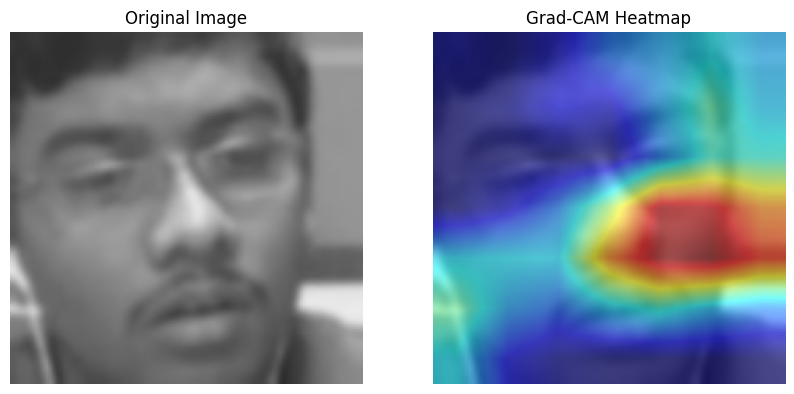

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


# Load the model
model = ResNetModel_IF()

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Specify target layers for Grad-CAM
target_layer = [model.image_cnn.layer4]

# Construct the CAM object once, and then re-use it on many images
cam = GradCAM(model=model, target_layers=target_layer)

# Function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    return img.unsqueeze(0)

# Path to the image
image_path = "/content/drive/MyDrive/WACV_engg_data/dataset/2/img23_17.jpg"
img_tensor = preprocess_image(image_path)

# Run Grad-CAM
grayscale_cam = cam(input_tensor=img_tensor, targets=None)
heatmap = grayscale_cam[0, :]  # Get the first (and only) image's heatmap

# Read the image using OpenCV
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))

# Apply the heatmap on the image
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
cam_img = show_cam_on_image(img / 255.0, heatmap_resized)  # Normalize img for proper overlay

# Plot the original image and the Grad-CAM heatmap
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [ ]:
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18


# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output
        print(f"Activations: {self.activations.shape}")

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        print(f"Gradients: {self.gradients.shape}")

    def forward(self, images):
        return self.model(images)

    def __call__(self, images, index=None):
        output = self.forward(images)

        if index is None:
            index = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[0, index]
        print(f"Class Score: {class_score.item()}")
        class_score.backward(retain_graph=True)

        if self.gradients is None:
            print("Gradients are not being captured.")
            return None

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        print(f"Pooled Gradients: {pooled_gradients}")

        if torch.all(pooled_gradients == 0):
            print("Pooled gradients are all zero.")
            return None

        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        print(f"Heatmap before ReLU: {heatmap}")

        heatmap = F.relu(heatmap)

        if torch.isnan(heatmap).any():
            print("NaN values found in heatmap, setting them to zero.")
            heatmap = torch.nan_to_num(heatmap, nan=0.0)

        heatmap = heatmap - heatmap.min()
        if heatmap.max() != 0:
            heatmap = heatmap / heatmap.max()

        print(f"Heatmap after normalization: {heatmap}")

        return heatmap.detach().cpu().numpy()

# Function to overlay the heatmap on the original image
def show_cam_on_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    return img.unsqueeze(0)

# Main function to apply Grad-CAM
def func(image_path, model_path):
    # Load the model
    model = ResNetModel_IF()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Specify target layers for Grad-CAM
    target_layer_options = [
        model.image_cnn.layer4[1].conv2,  # The original layer
        model.image_cnn.layer4[0].conv2,  # Earlier layer
        model.image_cnn.layer3[1].conv2,  # Even earlier layer
    ]

    for i, target_layer in enumerate(target_layer_options):
        print(f"\nTesting with target layer: {i + 1}")
        grad_cam = GradCAM(model, target_layer)

        img = preprocess_image(image_path)

        heatmap = grad_cam(img)

        if heatmap is None:
            print(f"Heatmap is None for target layer: {i + 1}. Skipping.")
            continue

        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        cam_img = show_cam_on_image(img / 255.0, heatmap)  # Normalize img for proper overlay

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Grad-CAM Layer {i + 1}")
        plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

image_path="/content/drive/MyDrive/WACV_engg_data/dataset/2/img23_17.jpg"
func(image_path, model_path)


In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, images, features):
        self.model.zero_grad()
        output = self.model(images, features)
        pred_class = output.argmax(dim=1)
        output[:, pred_class].backward()

        gradients = self.gradients
        activations = self.activations
        weights = F.adaptive_avg_pool2d(gradients, 1)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()

        return cam[0]

# Main function to apply Grad-CAM
def func(image_path, model_name, model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Specify target layers for Grad-CAM
    target_layer_options = [
        model.efficientnet.features[6],  # Select a layer from EfficientNet
        model.efficientnet.features[5],  # Earlier layer
        model.efficientnet.features[4],  # Even earlier layer
    ]

    for i, target_layer in enumerate(target_layer_options):
        print(f"\nTesting with target layer: {i + 1}")
        grad_cam = GradCAM(model, target_layer)

        img = preprocess_image(image_path)
        features = torch.randn(1, 709)  # Sample feature input

        heatmap = grad_cam(img.unsqueeze(0), features)

        if heatmap is None:
            print(f"Heatmap is None for target layer: {i + 1}. Skipping.")
            continue

        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        cam_img = show_cam_on_image(img / 255.0, heatmap)  # Normalize img for proper overlay

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Grad-CAM Layer {i + 1}")
        plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.savefig(f"{model_name}_grad_cam_layer_{i + 1}.pdf")
        plt.show()


In [ ]:
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output
        print(f"Activations: {self.activations.shape}")

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        print(f"Gradients: {self.gradients.shape}")

    def forward(self, images, features):
        return self.model(images, features)

    def __call__(self, images, features, index=None):
        output = self.forward(images, features)

        if index is None:
            index = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[0, index]
        print(f"Class Score: {class_score.item()}")
        class_score.backward(retain_graph=True)

        if self.gradients is None:
            print("Gradients are not being captured.")
            return None

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        print(f"Pooled Gradients: {pooled_gradients}")

        if torch.all(pooled_gradients == 0):
            print("Pooled gradients are all zero.")
            return None

        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        print(f"Heatmap before ReLU: {heatmap}")

        heatmap = F.relu(heatmap)

        if torch.isnan(heatmap).any():
            print("NaN values found in heatmap, setting them to zero.")
            heatmap = torch.nan_to_num(heatmap, nan=0.0)

        heatmap = heatmap - heatmap.min()
        if heatmap.max() != 0:
            heatmap = heatmap / heatmap.max()

        print(f"Heatmap after normalization: {heatmap}")

        return heatmap.detach().cpu().numpy()

In [ ]:
# Function to overlay the heatmap on the original image
def show_cam_on_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    return img.unsqueeze(0)

# Main function to apply Grad-CAM
def func(image_path,model_name,model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Specify target layers for Grad-CAM
    target_layer_options = [
        model.image_cnn.layer4[1].conv2,  # The original layer
        model.image_cnn.layer4[0].conv2,  # Earlier layer
        model.image_cnn.layer3[1].conv2,  # Even earlier layer
    ]

    for i, target_layer in enumerate(target_layer_options):
        print(f"\nTesting with target layer: {i + 1}")
        grad_cam = GradCAM(model, target_layer)

        img = preprocess_image(image_path)
        features = torch.randn(1, 709)  # Sample feature input

        heatmap = grad_cam(img.unsqueeze(0), features)

        if heatmap is None:
            print(f"Heatmap is None for target layer: {i + 1}. Skipping.")
            continue

        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        cam_img = show_cam_on_image(img / 255.0, heatmap)  # Normalize img for proper overlay

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Grad-CAM Layer {i + 1}")
        plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.savefig(f"{model_name}grad_cam_layer_{i + 1}.pdf")
        plt.show()
